# Introduction

This is a short tutorial on how to use the stellar model from Green+(2020).

This model predicts a star's absolute magnitude (in Gaia $G$ band) and colors ($X - G$, where $X \in \left\{ BP,RP,g,r,i,z,y,J,H,K_s,W_1,W_2 \right\}$), as a function of its spectroscopic labels $\vec{\theta} = \left( T_{\mathrm{eff}}, \log g, \left[ \mathrm{Fe} / \mathrm{H} \right] \right)$ and reddening $E$. The neural network models the extinguished photometry as
$$
  B \big[ \vec{M} \big( \vec{\theta} \, \big) + \underbrace{E \, \vec{R} \big( \vec{\theta} \big)}_{= \vec{A}} \big] \, ,
$$
where $\vec{M}$ are absolute magnitudes, $\vec{R}$ is the "reddening vector," and $B$ is the matrix
$$
  B \equiv
  \begin{pmatrix}
    1 & 0 & 0 & \cdots \\
    -1 & 1 & 0 & \cdots \\
    -1 & 0 & 1 & \\
    \vdots & \vdots & & \ddots
  \end{pmatrix}
  \, ,
$$
which transforms from absolute magnitudes to a vector containing one absolute magnitude and colors relative to the first passband.

In this tutorial, we will show how to load the neural network, input spectroscopic labels and reddenings, and interpret the output.

### Import Python modules

First, we load the necessary Python modules. The Green+(2020) model is built using [Tensorflow 2](https://www.tensorflow.org/), using the [Keras](https://www.tensorflow.org/guide/keras) submodule.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
print(f'Tensorflow version {tf.__version__}')

import tensorflow.keras as keras

Tensorflow version 2.2.0


### Load the neural network

If we don't already have it, we download the trained neural network.

In [2]:
!curl -L "https://faun.rc.fas.harvard.edu/pan1/ggreen/dd_stellar_models/green2020_nn_model.h5" > green2020_nn_model.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72416  100 72416    0     0  59947      0  0:00:01  0:00:01 --:--:-- 59947


Then, we load the trained neural network model, and print a summary of the structure of the model.

In [3]:
nn_model = tf.keras.models.load_model('green2020_nn_model.h5')
nn_model.summary()

Model: "green2020_stellar_photometry_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 3)]          0                                            
__________________________________________________________________________________________________
stellar_model_hidden_1 (Dense)  (None, 32)           128         theta[0][0]                      
__________________________________________________________________________________________________
E (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
R (Dense)                       (None, 13)           52          theta[0][0]                      
_________________________________________________________________

An attempt has been made to name the layers in a way which mirrors the terminology in Green+(2020). There are three input layers:

1. `theta`, which takes (normalized - see below) spectroscopic labels $\vec{\theta}$.
2. `E`, which takes reddening $E$.
3. `LT`, which takes $L^T$, the Cholesky decomposition of the covariance matrix of the vector $\vec{c}$ (see Green+2020).

All three inputs are needed when *training* the model on data. However, when *predicting* photometry for a given set of spectroscopic labels and reddenings, we do not need to know about the covariance matrices, so the third input is unnecessary. We will show below how to extract the prediction of $B \big( \vec{M} + \vec{A} \big)$ (represented by the layer `B_M_plus_A`) from the neural network.

### Normalization of spectroscopic labels

Before passing spectroscopic labels, $\theta$, into the neural network, we have to normalize them. We scale and shift $\left( T_{\mathrm{eff}}, \log g, \left[ \mathrm{Fe} / \mathrm{H} \right] \right)$ so that they are typically small numbers. Specifically, we scale and shift them based on the median and standard deviation of the training data.

First, if we don't already have it, we download a file containing the median and standard deviation of the training data:

In [4]:
!curl -L "https://faun.rc.fas.harvard.edu/pan1/ggreen/dd_stellar_models/green2020_theta_normalization.json" > green2020_theta_normalization.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   148  100   148    0     0    183      0 --:--:-- --:--:-- --:--:--   183


Then, we load the file and create a function that normalizes the spectroscopic labels.

In [5]:
import json

with open('theta_normalization.json', 'r') as f:
    d = json.load(f)

theta_med = np.array(d['theta_med'])
theta_std = np.array(d['theta_std'])

def normalize_theta(theta):
    """
    Normalizes spectroscopic labels, so that they can be input to neural
    network.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
    
    Returns:
      Normalized theta. The normalization is based on the mean and standard
      deviation of theta in the training dataset.
    """
    # theta_med = np.array([5372.02, 4.06696, -0.246082])
    # theta_std = np.array([902.802, 0.889269, 0.373921])
    x = (theta - theta_med[None,:]) / theta_std[None,:]
    return x

### Function from $\big( \vec{\theta}, E \big)$ to $B \big( \vec{M} + \vec{A} \big)$

Now, we extract the section of the neural network that predicts $B \big( \vec{M} + \vec{A} \big)$, the extinguished absolute magnitude in Gaia $G$ band, and the reddened colors $X-G$, where $X$ stands for $\left\{ BP,RP,g,r,i,z,y,J,H,K_s,W_1,W_2 \right\}$.

In [6]:
inputs = [
    nn_model.get_layer('theta').input,
    nn_model.get_layer('E').input
]
outputs = nn_model.get_layer(name='B_M_plus_A').output
B_M_plus_A_model = tf.keras.Model(inputs, outputs)

def predict_mag_color(theta, E):
    """
    Predicts extinguished absolute magnitude and colors, B(M+A), for
    a given set of spectroscopic labels, theta, and reddenings, E.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
      E (numpy.ndarray): Array containing reddening for each star (in an
          arbitrary unit, similar to the scale used by SFD'98).
          Shape = (# of stars,).
    
    Outputs:
      B(M+A), as a numpy.ndarray. Shape = (# of stars, 13).
    """
    x = normalize_theta(theta)
    E = np.reshape(E, (E.size,1))
    return B_M_plus_A_model([x, E]).numpy()

Let's predict the Sun's *G*-band absolute magnitude and colors (vs. *G*), through a dust extinction corresponding to $E = 1$:

In [7]:
predict_mag_color(np.array([[5780., 4.44, 0.0]]), np.array([1.]))

array([[ 7.244404  ,  1.1014011 , -1.1838574 ,  1.5001886 ,  0.05407166,
        -0.7627248 , -1.250402  , -1.56324   , -2.889452  , -3.552063  ,
        -3.7978451 , -1.2824153 , -0.63042474]], dtype=float32)

### Prediction on a grid of $\left( T_{\mathrm{eff}}, \log g \right)$
To illustrate how to use the neural network, we predict the unextinguished absolute magnitude and colors of stars on a grid in $\left( T_{\mathrm{eff}}, \log g \right)$, with $\left[ \mathrm{Fe}/\mathrm{H} \right] = 0$.

In [8]:
def input_grid(n_teff, n_logg, feh=0.):
    """
    Generates a grid in T_eff, logg, with constant [Fe/H].
    Also returns a vector of zeros for the reddenings.

    Inputs:
      n_teff (int): The # of grid points for T_eff.
      n_logg (int): The # of grid points for logg.
      feh (float): Constant [Fe/H] to fill grid with.

    Returns:
      theta (np.ndarray): A vector containing (T_eff, logg, [Fe/H]).
        Shape = (# of grid points, 3).
      E (np.ndarray): A zero-filled vector. Shape = (# of grid points,).
    """
    # Grid in (teff, logg)
    teff = np.linspace(3500., 8500., n_teff)
    logg = np.linspace(0., 6., n_logg)
    teff, logg = np.meshgrid(teff, logg)

    # [Fe/H] = 0
    feh0 = np.full_like(teff, feh)

    # Pack spectroscopic labels into one array
    theta = np.stack([teff, logg, feh0], axis=-1)
    theta.shape = (theta.shape[0]*theta.shape[1], 3)

    # Zero reddening
    E = np.zeros(theta.shape[0])

    return theta, E

In [9]:
theta, E = input_grid(100, 100)

BM = predict_mag_color(theta, E)

We plot color-magnitude diagrams of the results, colored both by $T_{\mathrm{eff}}$ and $\log g$.

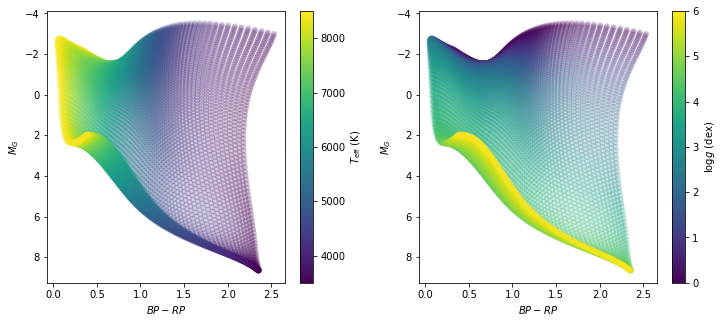

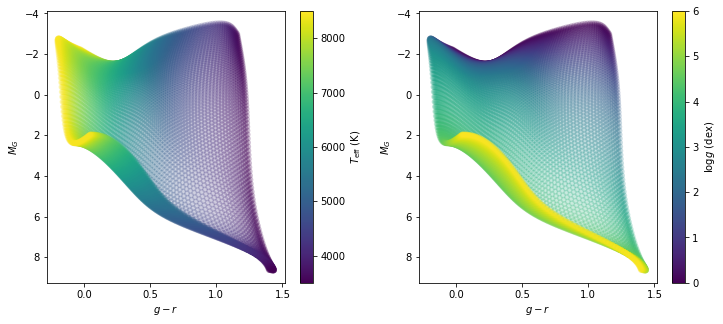

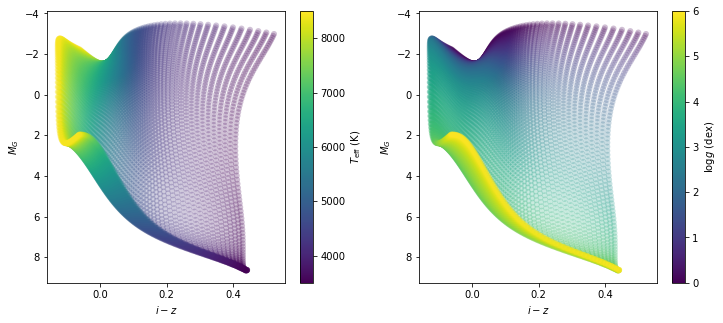

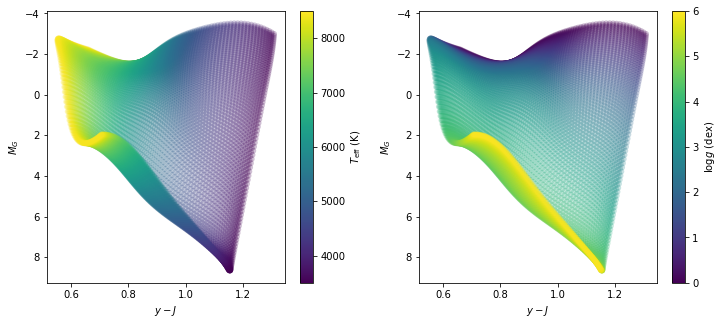

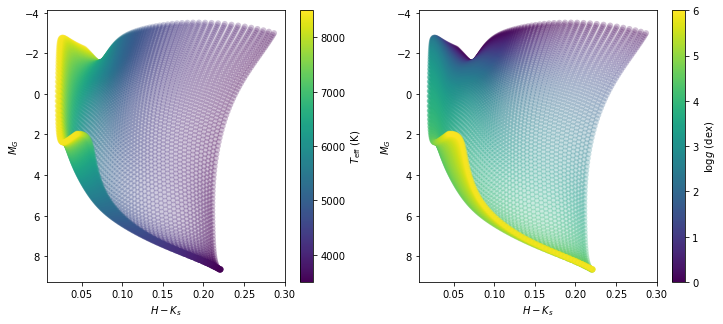

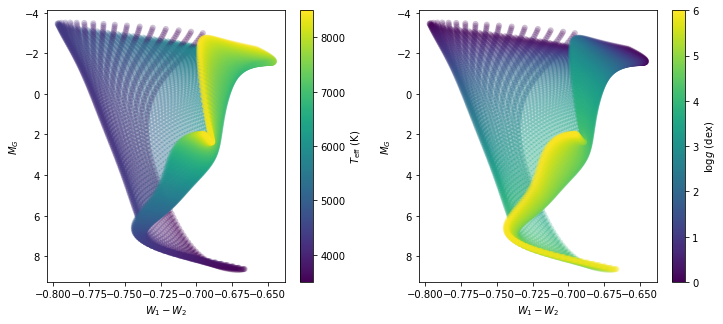

In [10]:
# All the bands (except G)
bands = ['BP', 'RP'] + list('grizyJH') + ['K_s', 'W_1', 'W_2']

# Plot each color
for k,(b1,b2) in enumerate(zip(bands[:-1:2],bands[1::2])):
    fig,ax_arr = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.25)

    # Plot both T_eff and logg
    theta_labels = [
        r'$T_{\mathrm{eff}}\ \left( \mathrm{K} \right)$',
        r'$\log g\ \left( \mathrm{dex} \right)$'
    ]
    for i,(ax,label) in enumerate(zip(ax_arr, theta_labels)):
        im = ax.scatter(
            BM[:,2*k+1]-BM[:,2*k+2],
            BM[:,0],
            c=theta[:,i],
            alpha=0.25,
            edgecolors='none'
        )
        cb = fig.colorbar(im, ax=ax, label=label)
        cb.set_alpha(1)
        cb.draw_all()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel(r'${}-{}$'.format(b1,b2))
        ax.set_ylabel(r'$M_G$')
    
    plt.show()

### Range of applicability of the model

The model is trained on stars with observed spectra, photometry and parallaxes. Not all stars are observed are observed in all passbands, and not all stars have parallax measurements. Our model's predictions of stellar photometry are only accurate in regions of $\vec{\theta}$-space in which we have training data. This range is different for each passband.

If we don't already have it, we download a dataset that contains the *density* of input data in $\vec{\theta}$-space for each passband:

In [11]:
!curl -L "https://faun.rc.fas.harvard.edu/pan1/ggreen/dd_stellar_models/green2020_input_density.h5" > green2020_input_density.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1754k  100 1754k    0     0   890k      0  0:00:01  0:00:01 --:--:--  890k


We load the dataset and create a function that takes a set of points in $\vec{\theta}$-space, as well as a band index, and returns the density of training data in the given values of $\vec{\theta}$. All stars are observed in *G*-band, so band 0 refers to *parallax* here. We can estimate the absolute magnitude in *G* for stars with observed parallaxes. Band 1 refers to *BP*, band 2 refers to *RP*, etc. If band $i$ is observed, then we can estimate its color vs. G: $m_i - m_G$.

In [12]:
import h5py
from scipy.interpolate import RegularGridInterpolator

with h5py.File('green2020_input_density.h5', 'r') as f:
    rho_stars = f['rho_stars'][:] # Density grid
    # Grid coordinates
    teff_range = f['rho_stars'].attrs['teff'][:]
    logg_range = f['rho_stars'].attrs['logg'][:]
    feh_range = f['rho_stars'].attrs['feh'][:]

# Construct interpolator for each band
grid = (teff_range, logg_range, feh_range)
rho_stars_interp = [
    RegularGridInterpolator(grid, rs, fill_value=0., bounds_error=False)
    for rs in rho_stars
]

def get_input_density(theta, band):
    """
    Returns the relative density of training data at the given points
    theta, for the given band.

    Inputs:
      theta (np.ndarray): Points in theta-space at which to evaluate the
          density of stars in the input dataset.
      band (int): Which band to evaluate the density for. 0 = parallax,
          1 = BP, 2 = RP, 3 = g, etc.
    
    Returns:
      The relative density of stars observed in the given band at the
      given points in theta-space in the input catalog that we used to
      train the model. The densities are normalized such that the maximum
      density for each band is 1.
    """
    return rho_stars_interp[band](theta)

We'll plot the density of stars with observed parallaxes and Gaia BP magnitudes, as a function of $T_{\mathrm{eff}}$ and $\log g$, with $\left[\mathrm{Fe}/\mathrm{H}\right] = 0$:

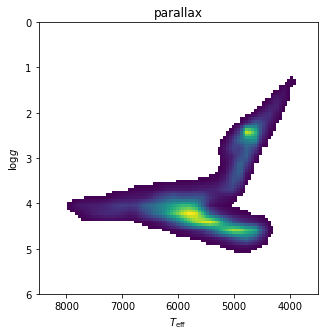

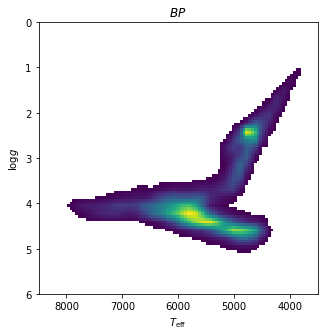

In [13]:
theta_grid,_ = input_grid(100, 100, feh=0.)

for b,title in enumerate(('parallax', r'$BP$')):
    img = get_input_density(theta_grid, b).reshape(100,100)
    img[img < 1.e-2] = np.nan # Make a cut on minimum density
    
    fig,ax = plt.subplots(1,1, figsize=(5,5))
    extent = (
        np.min(theta_grid[:,0]),
        np.max(theta_grid[:,0]),
        np.min(theta_grid[:,1]),
        np.max(theta_grid[:,1]),
    )
    ax.imshow(
        img,
        origin='lower',
        interpolation='nearest',
        extent=extent,
        aspect='auto'
    )
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel(r'$T_{\mathrm{eff}}$')
    ax.set_ylabel(r'$\log g$')
    ax.set_title(title)

We'll redo the plots we made above of the predicted *G*-band absolute magnitude and colors, this time, only showing regions of $\vec{\theta}$-space where the model predictions are reliable (i.e., where there was training data):

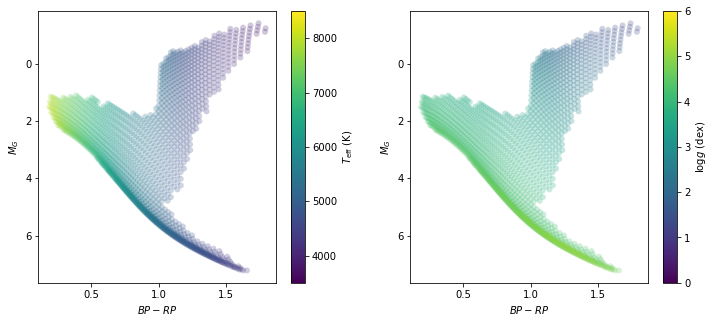

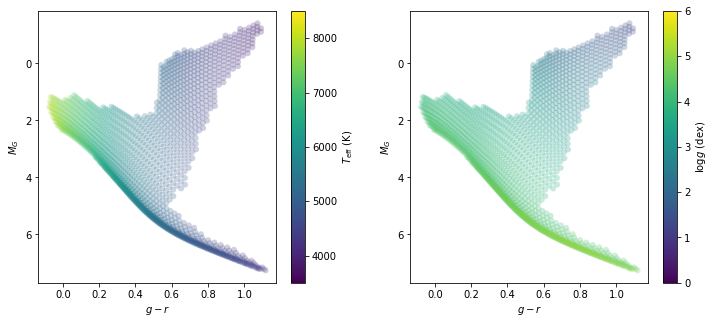

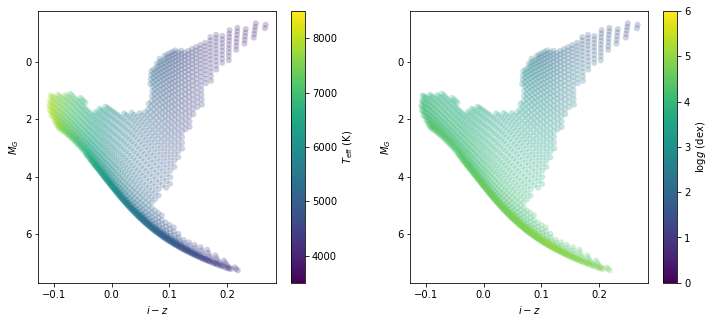

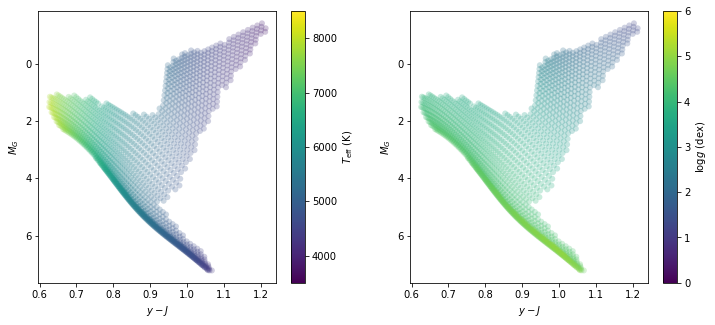

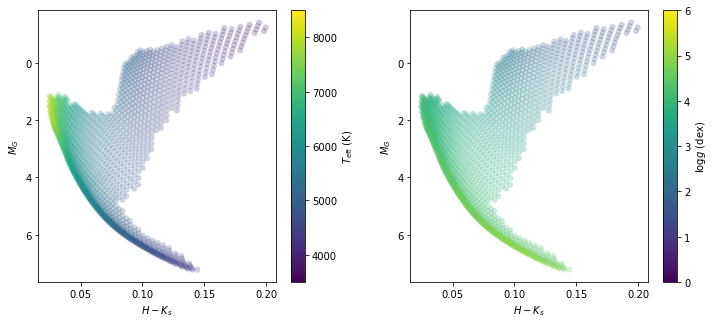

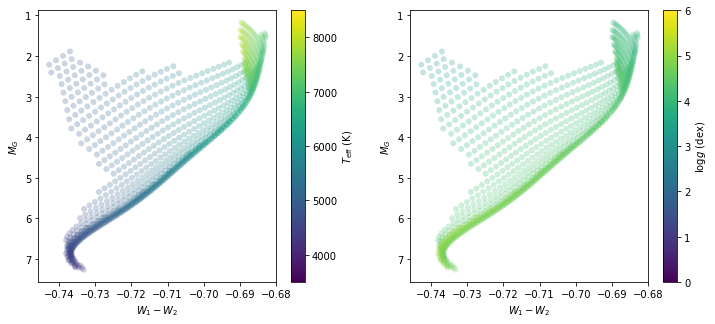

In [14]:
theta, E = input_grid(100, 100)
BM = predict_mag_color(theta, E)

# All the bands (except G)
bands = ['BP', 'RP'] + list('grizyJH') + ['K_s', 'W_1', 'W_2']

# We need parallax measurements to learn absolute magnitudes in G.
# We'll use a relative density of 0.01 as the threshold.
idx_G = (get_input_density(theta, 0) > 1.e-2)

# Plot each color
for k,(b1,b2) in enumerate(zip(bands[:-1:2],bands[1::2])):
    fig,ax_arr = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.25)
    
    # Determine region of applicability of the model in bands b1 and b2
    idx = (
        idx_G
        & (get_input_density(theta, 2*k+1) > 1.e-2)
        & (get_input_density(theta, 2*k+2) > 1.e-2)
    )

    # Plot both T_eff and logg
    theta_labels = [
        r'$T_{\mathrm{eff}}\ \left( \mathrm{K} \right)$',
        r'$\log g\ \left( \mathrm{dex} \right)$'
    ]
    for i,(ax,label) in enumerate(zip(ax_arr, theta_labels)):
        vmin,vmax = np.min(theta[:,i]), np.max(theta[:,i])

        im = ax.scatter(
            BM[idx,2*k+1]-BM[idx,2*k+2],
            BM[idx,0],
            c=theta[idx,i],
            alpha=0.25,
            edgecolors='none',
            vmin=vmin,
            vmax=vmax
        )
        cb = fig.colorbar(im, ax=ax, label=label)
        cb.set_alpha(1)
        cb.draw_all()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel(r'${}-{}$'.format(b1,b2))
        ax.set_ylabel(r'$M_G$')
    
    plt.show()

### Extracting the reddening vector

We can also extract the function that maps $\vec{\theta}$ to $\vec{R}$ from the full neural network model.

In [15]:
inputs = nn_model.get_layer('theta').input
outputs = nn_model.get_layer(name='R').output
R_model = tf.keras.Model(inputs, outputs)

def predict_R(theta):
    """
    Predicts the reddening vector, R, for a given set of
    spectroscopic labels, theta.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
    
    Outputs:
      R, the reddening vector. Shape = (# of stars, 13).
    """
    x = normalize_theta(theta)
    return R_model(x).numpy()

We predict $\vec{R}$ on a sparse grid in $\vec{\theta}$. We also predict the unextinguished absolute magnitude and colors of stars on the same grid, and then plot the reddening vector on a Gaia color-magnitude diagram.

In [16]:
theta, E = input_grid(20, 20)

BM = predict_mag_color(theta, E)
R = predict_R(theta)

# Range of applicability of the model
idx = (
    (get_input_density(theta, 1) > 1.e-2)
    & (get_input_density(theta, 2) > 1.e-2)
)

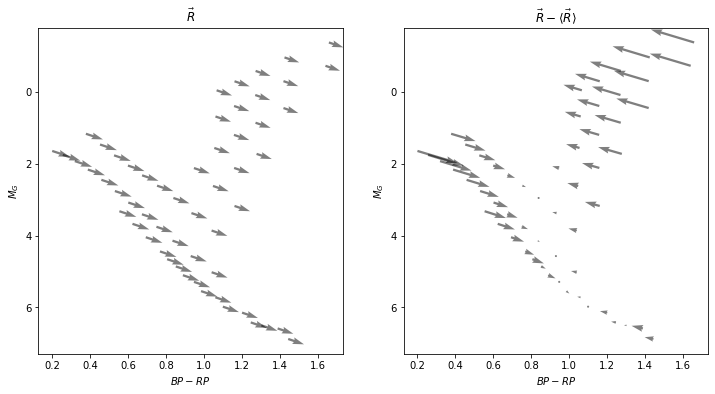

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.quiver(
    BM[idx,1]-BM[idx,2], # BP-RP
    BM[idx,0], # M_G
    R[idx,1]-R[idx,2], # R_BP - R_RP
    R[idx,0], # R_G
    angles='xy',
    alpha=0.5
)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlabel(r'$BP-RP$'.format(b1,b2))
ax1.set_ylabel(r'$M_G$')
ax1.set_title(r'$\vec{R}$')

R0 = np.mean(R, axis=0)
dR = R - R0[None,:]
ax2.quiver(
    BM[idx,1]-BM[idx,2], # BP-RP
    BM[idx,0], # M_G
    dR[idx,1]-dR[idx,2], # R_BP - R_RP
    dR[idx,0], # R_G
    angles='xy',
    alpha=0.5
)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel(r'$BP-RP$'.format(b1,b2))
ax2.set_ylabel(r'$M_G$')
ax2.set_title(r'$\vec{R} - \langle \vec{R} \rangle$')

plt.show()

Above, the right panel shows the difference between the reddening vector and the mean reddening vector (taking the mean over the grid points). The scaling of the reddening vectors are different between the two panels. The right panel exaggerates the variation in the reddening vector, in order to make it more apparent.

# More advanced tricks

Below are some more advanced things you can do with the network, which go beyond simply getting predictions out of it.

## Assessing the Model's Performance

We can evaluate the model's performance using small test dataset. First, if we don't already have it, we download the dataset:

In [18]:
!curl -L "https://faun.rc.fas.harvard.edu/pan1/ggreen/dd_stellar_models/green2020_test_data_small.h5" > green2020_test_data_small.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1537k  100 1537k    0     0   785k      0  0:00:01  0:00:01 --:--:--  785k


The file contains three arrays:

In [19]:
with h5py.File('green2020_test_data_small.h5', 'r') as f:
    d = f['data'][:]       # All the data needed to train or test the model
    r_fit = f['r_fit'][:]  # The reddening inferred using the trained model
    r_var = f['r_var'][:]  # The variance of the inferred reddening

print(d.dtype.names)

('atm_param', 'atm_param_cov', 'atm_param_p', 'atm_param_cov_p', 'r', 'r_err', 'mag', 'mag_err', 'parallax', 'parallax_err', 'atm_source', 'r_source')


The columns of the first array have the following meanings:

* `atm_param` : Spectroscopic labels, $\hat{\theta}$. `shape = (# of stars, 3)`.
* `atm_param_cov` : Covariance of spectroscopic labels, $C_{\theta}$. `shape = (# of stars, 13, 13)`
* `atm_param_p` : Like `atm_param`, but in normalized coordinates.
* `atm_param_cov_p` : Like `atm_param_cov`, but in normalized coordinates.
* `r` : Reddening estimate, $\hat{E}$. `shape = (# of stars,)`.
* `r_err` : Uncertainty in reddening estimate, $\sigma_E$.
* `mag` : Observed magnitudes, $\hat{m}$. `shape = (# of stars, 13)`.
* `mag_err` : Uncertainties in observed magnitudes, $\vec{\sigma}_m$.
* `parallax` : Observed parallaxes, $\hat{\varpi}$. `shape = (# of stars,)`.
* `parallax_err` : Uncertainties in observed parallaxes, $\sigma_{\varpi}$.
* `atm_source` : The survey that the spectroscopic labels come from. `shape = (# of stars,)`.
* `r_source` : The source of the reddening estimates. `shape = (# of stars,)`.

In order to calculate a $\chi^2$ loss, our model takes in the Cholesky decomposition, $L^T$, of the inverse covariance matrix, $C_m^{-1}$. We can calculate this covariance matrix from the information in our input dataset.

From Green+(2020), to linear order in the (measurement - truth) errors $\delta \vec{\theta}$ (spectroscopic labels), $\delta \varpi$ (parallax), $\delta E$ (reddening) and $\delta \vec{m}$ (observed photometry), observed apparent magnitudes are given by
$$
    \hat{m} = \,
        \vec{M} \big( \hat{\theta} \big)
      + \mu \big( \hat{\varpi} \big)
      + \hat{E} \, \vec{R} \big( \hat{\theta} \big)
      \ - \ 
        \left(
          \delta \vec{\theta} \cdot
          \nabla_{\vec{\theta}}
        \right) \!\!
        \left.
        \left(
          \vec{M} + \hat{E} \, \vec{R}
        \right)
        \right|_{\vec{\theta} = \hat{\theta}}
      - \delta \varpi \left.
          \frac{\partial \mu}{\partial \varpi}
        \right|_{\varpi=\hat{\varpi}}
      \!\!\!
      - \delta E \, \vec{R}
      + \delta \vec{m}
    \, .
$$
The covariance matrix of the difference between the predicted and observed apparent magnitudes is therefore given by
$$
  C_{m ,\, ij} =
      \sum_{k\ell}
        \frac{\partial (M_i \!+\! \hat{E} R_i)}{\partial \theta_k}
        \frac{\partial (M_j \!+\! \hat{E} R_j)}{\partial \theta_{\ell}}
        \, C_{\theta ,\, k \ell}
    + R_i R_j \sigma_E^2
    + \left| \frac{5}{\ln 10} \frac{\sigma_{\varpi}}{\hat{\varpi}} \right|^2
    + \delta_{ij} \sigma_{m , i}^2 \, ,
$$
where $C_{\theta}$ is the covariance matrix for the spectroscopic labels, $\sigma_E$ is the uncertainty on the reddening estimate, $\sigma_{\varpi}$ is the uncertainty in the observed parallax, and $\sigma_{m,i}$ is the observational uncertainty of the observed magnitude in band $i$.

In [20]:
def get_cov(use_r_fit=False):
    n_stars, n_bands = d['mag'].shape

    large_err = 999. # A large error, in magnitudes

    # Observed y = B(m - distmod) and its covariance
    y = d['mag'].copy() # Begin with observed apparent magnitudes
    cov_y = np.zeros((n_stars, n_bands, n_bands))

    # Photometric contribution to covariance: sigma_m^2
    for b in range(n_bands):
        cov_y[:,b,b] = d['mag_err'][:,b]**2

    # Replace unobserved mags with median, and blow up corresponding errors
    for b in range(n_bands):
        idx = ~np.isfinite(y[:,b]) | ~np.isfinite(cov_y[:,b,b])
        y[idx,b] = np.nanmedian(y[:,b])
        cov_y[idx,b,b] = large_err**2.

    # Transform both y and its covariance to (mag,color)-space
    B = np.identity(n_bands, dtype='f4')
    B[1:,0] = -1.

    y = np.einsum('ij,nj->ni', B, y) # y' = B y
    # C' = B C B^T
    cov_y = np.einsum('nik,jk->nij', cov_y, B)
    cov_y = np.einsum('ik,nkj->nij', B, cov_y)

    # Subtract distance modulus from G-band apparent magnitude
    dm = 10. - 5.*np.log10(d['parallax'])
    y[:,0] -= dm

    # Parallax contribution to covariance
    err_over_plx = d['parallax_err'] / d['parallax']
    cov_y[:,0,0] += (5./np.log(10.) * err_over_plx)**2.

    # Don't attempt to predict M_G for poor plx/err or when plx < 0
    idx = (
          (err_over_plx > 0.2)
        | (d['parallax'] < 1.e-8)
        | ~np.isfinite(d['parallax'])
        | ~np.isfinite(d['parallax_err'])
    )
    cov_y[idx,0,0] = large_err**2
    y[idx,0] = np.nanmedian(y[:,0])

    # Reddening contribtion to covariance: sigma_r^2 (BR) (BR)^T
    R = predict_R(d['atm_param_p'])
    BR = np.einsum('ij,nj->ni', B, R)
    if use_r_fit:
        cov_y += (d['r_err']**2)[:,None,None] * BR[:,:,None] * BR[:,None,:]
    else:
        cov_y += r_var[:,None,None] * BR[:,:,None] * BR[:,None,:]

    # Theta contribution to covariance: J C_theta J^T,
    # where J := d[B(M+ER)]/dtheta
    with tf.GradientTape() as g:
        x_p = tf.constant(d['atm_param_p'])
        if use_r_fit:
            E = tf.constant(r_fit)
        else:
            E = tf.constant(d['r'])
        g.watch(x_p)
        mag_color = B_M_plus_A_model([x_p, E]) # Forward pass through model
    J = g.batch_jacobian(mag_color, x_p).numpy() # Calculate Jacobian
    cov_y += np.einsum('nik,nkl,njl->nij', J, d['atm_param_cov_p'], J)

    return y, cov_y

In [21]:
y, cov_y = get_cov()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


Now, we invert the covariance matrix for each star, and calculate the Cholesky decomposition:
$$
  L L^T = C_m^{-1} \, .
$$
We also calculate $L^T B \left( \vec{m} - \mu \right)$, which is the expected output from our neural network.

In [22]:
def get_LT(cov_y):
    inv_cov_y = np.empty_like(cov_y)
    LT = np.empty_like(cov_y)
    LTy = np.empty_like(y) # L^T y, where y := B(m-distmod)

    for k,c in enumerate(cov_y):
        # Inflate diagonal of cov slightly, to ensure
        # positive-definiteness
        c_diag = c[np.diag_indices_from(c)]
        c[np.diag_indices_from(c)] += 1.e-4 + 1.e-3 * c_diag

        inv_cov_y[k] = np.linalg.inv(c)
        LT[k] = np.linalg.cholesky(inv_cov_y[k]).T

    LTy = np.einsum('nij,nj->ni', LT, y)

    return LT, LTy

In [23]:
LT, LTy = get_LT(cov_y)

Now that we have all the required inputs and outputs for the neural network model, we can evaluate the model's performance. We evaluate the mean square error (MSE) and loss (which includes additional regularization terms). We split the stars into three groups, depending on where the reddening estimate comes from. There are three sources of reddening estimates:

* `sfd` : Schlegel, Finkbeiner & Davis (1998). We use this estimate for stars that are more than 400 pc above or below the midplane of the Galaxy.
* `b19` : Bayestar19 (Green+2019). We use this estimate for stars in the midplane of the Galaxy that have well-measured parallaxes.
* `default`: All other stars are assigned a reddening of $0 \pm \mathrm{SFD}$. These stars are primarily in the Galactic midplane, but either 
have poorly measured parallaxes or are outside the footprint of Bayestar19.

In [24]:
def get_loss(theta, r, LT, LTy):
    inputs = [theta, r, LT]
    outputs = LTy

    loss,mse = nn_model.evaluate(
        inputs,
        outputs,
        batch_size=32,
        verbose=0
    )

    return loss,mse

for r_source in ['sfd', 'b19', 'default']:
    idx = [rs.decode() == r_source for rs in d['r_source']]
    loss,mse = get_loss(d['atm_param_p'][idx], d['r'][idx], LT[idx], LTy[idx])
    n = np.count_nonzero(idx)

    print(f'Reddening estimate comes from {r_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

Reddening estimate comes from sfd (n = 3965):
               mse (chi^2/band) = 0.6992
    loss (mse + regularization) = 0.7155

Reddening estimate comes from b19 (n = 5086):
               mse (chi^2/band) = 1.2826
    loss (mse + regularization) = 1.2989

Reddening estimate comes from default (n = 949):
               mse (chi^2/band) = 17.1647
    loss (mse + regularization) = 17.1810



As expected, stars with `default` reddening estimates have the worst loss. In Green+(2020), we use the trained model to update the stellar reddening estimates, which significantly reduces the loss. The stars with reddenings from `sfd` fare best, because the reddenings far away from the Galactic plane are better determined than the distance-dependent reddenings in the Galactic plane.

We can also split input data by the spectroscopic survey used to obtain spectroscopic labels. We additionally require that the reddenings come from SFD:

In [25]:
idx_r = np.array([rs.decode() == 'sfd' for rs in d['r_source']])

for atm_source in ['lamost', 'apogee', 'galah']:
    idx_atm = np.array([rs.decode() == atm_source for rs in d['atm_source']])
    idx = idx_r & idx_atm
    loss,mse = get_loss(d['atm_param_p'][idx], d['r'][idx], LT[idx], LTy[idx])
    n = np.count_nonzero(idx)

    print(f'Spectroscopic labels come from {atm_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

Spectroscopic labels come from lamost (n = 3511):
               mse (chi^2/band) = 0.7174
    loss (mse + regularization) = 0.7337

Spectroscopic labels come from apogee (n = 247):
               mse (chi^2/band) = 0.6708
    loss (mse + regularization) = 0.6871

Spectroscopic labels come from galah (n = 207):
               mse (chi^2/band) = 0.4236
    loss (mse + regularization) = 0.4400



Instead of using the original reddening estimates, we can use the updated reddening estimates. These updated estimates were obtained by predicting the intrinsic magnitudes of the stars using their spectroscopic labels, and comparing to the observed magnitudes. We still break down the losses based on the source of the original reddening estimates, so that they can be compared with what we calculated before.

In [26]:
y, cov_y = get_cov(use_r_fit=True)
LT, LTy = get_LT(cov_y)

for r_source in ['sfd', 'b19', 'default']:
    idx = [rs.decode() == r_source for rs in d['r_source']]
    loss,mse = get_loss(d['atm_param_p'][idx], r_fit[idx], LT[idx], LTy[idx])

    n = np.count_nonzero(idx)

    print(f'Original reddening estimate comes from {r_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


Original reddening estimate comes from sfd (n = 3965):
               mse (chi^2/band) = 0.5393
    loss (mse + regularization) = 0.5556

Original reddening estimate comes from b19 (n = 5086):
               mse (chi^2/band) = 0.8096
    loss (mse + regularization) = 0.8259

Original reddening estimate comes from default (n = 949):
               mse (chi^2/band) = 2.4672
    loss (mse + regularization) = 2.4835



Loss improves (decreases) for each category of stars. As expected, the improvement is most dramatic for stars that originally had `default` reddening estimates.